In [1]:
!pip install tushare
import tushare as ts
!pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries
import requests
import pandas as pd
#!pip install -U "ray[default]"
!pip install gymnasium
#!pip install 'ray[rllib]'
!pip install 'ray[all]'
import gymnasium
from gymnasium import spaces
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.misc import SlimFC
import math
from collections import deque
from datetime import datetime, timedelta
from os import close
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.ppo import PPO  # Import PPOTrainer
from ray.rllib.algorithms.ppo import PPOConfig
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.misc import SlimFC
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import EnvContext
from ray.tune.registry import register_env
np.random.seed(135)
torch.manual_seed(135)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/5

Setup Env

In [2]:
class PortfolioOptimizationEnv(gymnasium.Env):
    '''
    Environment setting with OpenAI

    Assumptions:
    1. In this case, the team has loose the constrain of 24 hours holding period. Once a person buy in the stock, the person can sell it immediately
    2. We have simplified the buy order mechanism so that stocks can be bought at the closing price of the day in this environment.

    State: A stack of stock price data, stock index data, current stock volums, current cash amount
    Observation: Same with state but in a 365 trading days duration
    Action: A float list with a length of N (number of stocks chosen) which elements are within range (-1,1). When positive -> buy Ni * cash amount of stock i. When negtive -> sell Ni present of stocki's volume

    '''

    def __init__(self,env_config):
        super(PortfolioOptimizationEnv, self).__init__()
        try:
            self.history_length = env_config['history_length']
            self.start = env_config['start']                        #define start date
            self.end = env_config['end']                            #define end date
            self.market = env_config['market']                      #define market -> currently only China
            self.n_stock = env_config['n_stock']                    #define the number of stock chosen
            self.cash = env_config['cash']                          #define the initial cash we take into the market
            self.smoothing_factor = env_config['smoothing_factor']  #define smooth for the DSR reward function

            self.market_data = self.load_market_data(self.start, self.end, self.market)         #Initialize market data during the start to end -> execute once to shorten running time
            self.close_data = self.load_full_close_data(self.start, self.end, self.market)      #Initialize close data

            self.stock_tensor_length = self.market_data.shape[1] - 1                                    #See observation_space
            self.date_list = self.load_trading_days(self.start, self.end, self.market)                  #Filter trading days from the period
            self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_stock,), dtype=np.float32)     #define action space, please see 'Action' in the class comment for detail
            self.observation_space = spaces.Box(                                                        #define observation space as required by Rllib, the observation space have to be a flattened np list
                low=-np.inf, high=np.inf,                                                               #Thus the dimension is calcualted as shape
                shape=(self.history_length * (self.stock_tensor_length + self.n_stock + 1 + self.n_stock + 1),),
                dtype=np.float32
            )

            self.state_buffer = deque(maxlen=self.history_length)           #define state deque
            self.initial_cash = np.float32(self.cash)                       #define cash buffer
            self.stock_volume = np.zeros(self.n_stock, dtype=np.float32)    #define stock volume recorder

            self.A_t = np.float32(0.0)
            self.B_t = np.float32(0.0)
            self.Previous_A_t = np.float32(0.0)
            self.Previous_B_t = np.float32(0.0)                             #define reward parameters
            self.net_price = np.array([], dtype=np.float32)                 #define net price loader
            self.current_step = 0                                           #define step recorder

        except Exception as e:
            print("Error during initialization:", e)
            raise


    def step(self, action):
        '''
        Step function, step forward according to policy model's return
        '''

        self.current_step += 1
        next_date = self.date_list[self.current_step]
        action = self.normalize_action(action)
        reward = self.calculate_reward(action, next_date)

        next_state = self.get_state(self.current_step, action,  reward, next_date)
        stacked_state = np.array(self.state_buffer).flatten().astype(np.float32)
        stacked_state = np.nan_to_num(stacked_state, nan=1e-8, posinf=999999, neginf=-999999)

        done = self.net_price[-1] <= 0
        turncated = self.current_step >= len(self.date_list) - 1
        info = {
                "net_price": self.net_price[-1],  # Pass the current net price
                "cash": self.cash,  # Example: Pass cash if needed
            }

        '''log monitoring -> comment back when needed
        if self.current_step % 100 == 0:
          print('-------------------------------------------------')
          print(f'The net price is: {self.net_price[-1]}')
          print(f'The current step is: {self.current_step}')
          print(f'The cash is :{self.cash}')
          print(f'The stock volume is :{self.stock_volume}')
          print(f'The actions are: {action}')
        '''


        return stacked_state, reward, done, turncated, info




    def reset(self, seed = None, options = None):
        '''
        Reset function, reset the environment when an episode is done
        '''
        if seed is not None:
          np.random.seed(seed)
          torch.manual_seed(seed)
        self.state_buffer = deque(maxlen=self.history_length)
        self.cash = self.initial_cash
        self.stock_volume = np.zeros_like(self.stock_volume)
        self.A_t = np.float32(0.0)
        self.B_t = np.float32(0.0)
        self.Previous_A_t = np.float32(0.0)
        self.Previous_B_t = np.float32(0.0)
        self.net_price = np.zeros(self.history_length, dtype=np.float32)
        self.current_step = self.history_length

        self.date_list = self.load_trading_days(self.start, self.end, self.market)
        first_365_days = self.date_list[:self.history_length]

        for idx, date in enumerate(first_365_days):
            dummy_action = np.zeros(self.action_space.shape, dtype=np.float32)
            dummy_reward = 0.0
            next_state = self.get_state(idx, dummy_action, dummy_reward, date)

        stacked_state = np.array(self.state_buffer).flatten()
        stacked_state = stacked_state.astype(np.float32)
        stacked_state = np.nan_to_num(stacked_state, nan=1e-8, posinf=999999, neginf=-999999)
        return stacked_state, {}




    def get_state(self, idx, action, reward, date):
        '''
        Obtain state and return to step function
        '''
        stock_data_current = self.market_data[self.market_data['trade_date'] == date].iloc[0].drop(['trade_date']).values
        reward_array = np.array([reward], dtype=np.float32)
        net_price_current = np.array([self.net_price[self.current_step-1]], dtype=np.float32)
        full_state = np.concatenate([stock_data_current, action, reward_array, self.stock_volume, net_price_current])
        date_encodings = self.calculate_date_encoding(idx, full_state.shape[0])
        full_state_with_encoding = full_state + date_encodings
        self.state_buffer.append(full_state_with_encoding)
        return full_state_with_encoding



    def load_trading_days(self, start, end, market):
        '''
        Filter trading days
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()
            trade_cal = pro.trade_cal(exchange = '',start_date = start, end_date = end)
            trade_cal = trade_cal[trade_cal['is_open'] == 1]
            trading_dates = trade_cal['cal_date'].tolist()
            return trading_dates
        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')




    def load_full_close_data(self, start, end, market='CHINA'):
        '''
        Load close price , the close price is loaded separately for calculating cumulative return and net price
        The close price in the "load_market_data" function has been normalized; thus need to load separately
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()
            stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
            df_close = pd.DataFrame()

            for code in stock_codes:
                df = pro.daily(ts_code=code, start_date=start, end_date=end)
                df = df[['trade_date', 'close']]
                df_renamed = df.rename(columns={'close': f"close_{code.split('.')[0]}"})

                if df_close.empty:
                    df_close = df_renamed
                else:
                    df_close = pd.merge(df_close, df_renamed, on='trade_date', how='outer')

            df_close.sort_values('trade_date', inplace=True)
            return df_close

        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')



    def load_close_data(self, date):
            '''
            Load close price for a specific day
            '''
            data_on_date = self.close_data[self.close_data['trade_date'] == date]
            close_columns = [col for col in data_on_date.columns if 'close_' in col]
            close_array = data_on_date[close_columns].values.flatten().astype(np.float32)
            return close_array



    def load_market_data(self, start, end, market='CHINA'):
        '''
        Load the market data and normalize it
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()

            stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
            Full_CHINA_STOCK_df = pd.DataFrame()

            for code in stock_codes:
                df = pro.daily(ts_code=code, start_date=start, end_date=end)
                adj_factors = pro.adj_factor(ts_code=code, start_date=start, end_date=end)
                daily_basic = pro.daily_basic(ts_code=code, start_date=start, end_date=end)
                daily_basic = daily_basic.drop(columns=['close'])

                df = pd.merge(df, adj_factors[['trade_date', 'adj_factor']], on='trade_date', how='left')
                df['close_adj'] = df['close'] / df['adj_factor']
                df['open_adj'] = df['open'] / df['adj_factor']
                df['high_adj'] = df['high'] / df['adj_factor']
                df['low_adj'] = df['low'] / df['adj_factor']
                df['close_price'] = df['close']
                df = pd.merge(df, daily_basic, on='trade_date', how='left')
                df = df.drop(columns=['adj_factor', 'ts_code_x','ts_code_y','close'])
                df_renamed = df.rename(columns=lambda x: f"{x}_{code.split('.')[0]}" if x != 'trade_date' else x)

                if Full_CHINA_STOCK_df.empty:
                    Full_CHINA_STOCK_df = df_renamed
                else:
                    Full_CHINA_STOCK_df = pd.merge(Full_CHINA_STOCK_df, df_renamed, on='trade_date', how='outer')

            Full_CHINA_STOCK_df.sort_values('trade_date', inplace=True)
            columns_to_normalize = [col for col in Full_CHINA_STOCK_df.columns if col != 'trade_date']
            scaler = MinMaxScaler()
            Full_CHINA_STOCK_df[columns_to_normalize] = scaler.fit_transform(Full_CHINA_STOCK_df[columns_to_normalize])

            return Full_CHINA_STOCK_df

        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')



    def calculate_date_encoding(self, idx, embedding_dimension):
        '''
        Add date encoding to the data according to the paper "Attention is all you need" by Vaswani et al.
        But somehow it also works on our value function which is a LSTM setting in this case. Need further investigate

        Also. there are two possible method to implement this embedding, one put it here follow the instruction in 'attention is all you need',
        two you can put it within the model to make it trainable parameters, we will investigate on this
        '''
        encoding = []
        for i in range(embedding_dimension):
            if i % 2 == 0:
                value = np.sin(idx / (10000 ** (i / embedding_dimension)))
            else:
                value = np.cos(idx / (10000 ** (i / embedding_dimension)))
            encoding.append(value)
        return np.array(encoding, dtype=np.float32)




    def calculate_reward(self, action, date):
        '''
        Implement Differencial Sharpe Ratio (DSR) as the reward function to take in consideration of the risk
        '''

        portfolio_return = self.get_portfolio_return(action, date)
        self.Previous_A_t = self.A_t.copy()
        self.Previous_B_t = self.B_t.copy()
        self.A_t = (1 - self.smoothing_factor) * self.A_t + self.smoothing_factor * portfolio_return
        self.B_t = (1 - self.smoothing_factor) * self.B_t + self.smoothing_factor * (portfolio_return ** 2)

        delta_A_t = portfolio_return - self.Previous_A_t
        delta_B_t = (portfolio_return**2) - self.Previous_B_t

        if self.Previous_B_t - (self.Previous_A_t ** 2) > 0:
            denom = (self.Previous_B_t - (self.Previous_A_t ** 2)) ** 1.5
            numer = self.Previous_B_t * delta_A_t - 0.5 * self.Previous_A_t * delta_B_t
            DSR = numer / denom
        else:
            DSR = 0
        return DSR



    def calculate_net_price(self, action, date):
        '''
        Calcualte the net price for a day
        '''
        close_values = self.load_close_data(date)
        for idx, act in enumerate(action):
            if act > 0:
                self.stock_volume[idx] += (self.cash * act) / close_values[idx]
                self.cash -= self.cash * act
            elif act < 0:
                self.cash += (-act) * self.stock_volume[idx] * close_values[idx]
                self.stock_volume[idx] += self.stock_volume[idx] * act
        net_price_value = self.cash + np.sum(self.stock_volume * close_values)
        self.net_price = np.append(self.net_price, net_price_value)
        return net_price_value



    def get_portfolio_return(self, action, date):
        '''
        Calcualte the return for a day
        '''
        current_price = self.calculate_net_price(action, date)
        last_day = self.current_step - 2
        previous_price = self.net_price[last_day]
        return np.float32(current_price - previous_price)



    def normalize_action(self, action):
        '''
        Since the positive action sampled from the policy model does not always sum up to 1 which represent over 100% of the cash, thus we needs to normalize it
        '''
        positive_mask = (action >= 0).astype(np.float32)
        positive_action = action * positive_mask
        positive_sum = np.sum(positive_action)
        if positive_sum > 1:
            positive_action = positive_action / positive_sum
        action = action * (1 - positive_mask) + positive_action

        for i, a in enumerate(action):
            if a < 0:
              if self.stock_volume[i] > 0:
                continue
              else:
                action[i] = 0
        return action


Build Transformer Actor and Critic

In [3]:

#Code Reference: University of Toronto ECE1786 Assignment3 Author: Jonathan Rose
class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """


    def __init__(self, model_config):
        super().__init__()
        assert model_config['n_embd'] % model_config['n_head'] == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(model_config['n_embd'], 3 * model_config['n_embd'])
        # output projection
        self.c_proj = nn.Linear(model_config['n_embd'], model_config['n_embd'])
        # regularization
        self.attn_dropout = nn.Dropout(model_config['attn_pdrop'])
        self.resid_dropout = nn.Dropout(model_config['resid_pdrop'])
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(model_config['block_size'], model_config['block_size']))
                                     .view(1, 1, model_config['block_size'], model_config['block_size']))
        self.n_head = model_config['n_head']
        self.n_embd = model_config['n_embd']



    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y



class Block(nn.Module):
    """ an unassuming Transformer block """
    def __init__(self, model_config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(model_config['n_embd'])
        self.attn = CausalSelfAttention(model_config)
        self.ln_2 = nn.LayerNorm(model_config['n_embd'])
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(model_config['n_embd'], 4 * model_config['n_embd']),
            c_proj  = nn.Linear(4 * model_config['n_embd'], model_config['n_embd']),
            act     = NewGELU(),
            dropout = nn.Dropout(model_config['resid_pdrop']),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward



    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x



# This actor model is responsible for choosing the actions for cash allocation
class CustomActorCriticModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        custom_model_config = model_config['custom_model_config']
        self.n_embd = custom_model_config['n_embd']
        self.n_layer = custom_model_config['n_layer']
        self.n_head = custom_model_config['n_head']
        self.block_size = custom_model_config['block_size']
        self.embd_pdrop = custom_model_config['embd_pdrop']
        self.resid_pdrop = custom_model_config['resid_pdrop']
        self.attn_pdrop = custom_model_config['attn_pdrop']

        self.transformer = nn.ModuleDict({
            'drop': nn.Dropout(self.embd_pdrop),
            'h': nn.ModuleList([Block(custom_model_config) for _ in range(self.n_layer)]),
            'ln_f': nn.LayerNorm(self.n_embd),
        })

        self.policy_head = nn.Linear(self.n_embd, num_outputs)
        self.value_head = nn.Linear(self.n_embd, 1)
        self.apply(self._init_weights)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)



    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)



    def forward(self, input_dict, state, seq_lens):

        if isinstance(input_dict['obs'], np.ndarray):
            obs = torch.tensor(input_dict['obs'], dtype=torch.float32).to(self.device)
        else:
            obs = input_dict['obs'].to(self.device)

        batch_size = obs.size(0)
        orig = obs.size(1)
        obs = obs.view(batch_size, orig//self.n_embd, self.n_embd )
        x = self.transformer.drop(obs)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        last_hidden_state = x[:, -1, :]

        policy = self.policy_head(last_hidden_state)
        value = self.value_head(last_hidden_state)
        self._value_out = self.value_head(last_hidden_state).squeeze(-1)
        return policy, state

    def value_function(self):
        return self._value_out

ModelCatalog.register_custom_model('custom_actor_critic_model',CustomActorCriticModel)

In [4]:
class CustomMetricsCallback(DefaultCallbacks):
    '''
    Custom call back class to monitor the net price
    '''
    def on_episode_end(self, *, worker, base_env, policies, episode, **kwargs):
        #print(f"The episode is {episode}")
        env = base_env.get_sub_environments()[0]
        final_net_price = env.net_price[-1] if len(env.net_price) > 0 else None
        if final_net_price is not None:
            episode.custom_metrics["final_net_price"] = final_net_price


In [5]:

config = {
    'env': 'my_portfolio_env',
    'num_workers': 0,
    'num_gpus': 1,
    'framework': 'torch',
    'env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 365,
        'market': 'CHINA',
        'start': '20210101',
        'end': '20230631',
        'smoothing_factor': 0.5
    },
    'val_env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20230701',
        'end': '20231231',
        'smoothing_factor': 0.5
    },
    'model': {
        'custom_model': 'custom_actor_critic_model',
        'custom_action_dist': None,
        'vf_share_layers': True,
        'custom_model_config': {
            'n_embd': 152,
            'n_layer': 2,
            'n_head': 2,
            'block_size': 512,
            'embd_pdrop': 0.1,
            'resid_pdrop': 0.1,
            'attn_pdrop': 0.1
        }
    },

    'lr': 1e-4, #change 4
    'train_batch_size': 512,
    'sgd_minibatch_size': 16,
    'num_epochs': 100,
    'callbacks': CustomMetricsCallback,
}

2024-11-25 04:07:21,562	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-11-25 04:07:23,305	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-11-25 04:07:41,151	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 04:07:46,807	INFO trainable.py:161 -- Trainable.setup took 23.469 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 04:07:46,811	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.1


2024-11-25 04:08:12,786	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


Training iteration 1, Hyperparameter tuned = 0.1
Epoch 1: Policy Loss=-0.022928822338581085, Value Loss=5.968498412966728
Training iteration 2, Hyperparameter tuned = 0.1
Epoch 2: Policy Loss=-0.01770010495558381, Value Loss=5.373726914525032
Training iteration 3, Hyperparameter tuned = 0.1
Epoch 3: Policy Loss=-0.013606549696996808, Value Loss=5.3366623955965045
Training iteration 4, Hyperparameter tuned = 0.1
Epoch 4: Policy Loss=-0.02473400527611375, Value Loss=6.16128120303154
Training iteration 5, Hyperparameter tuned = 0.1
Epoch 5: Policy Loss=-0.02529741369187832, Value Loss=3.972988721728325
Training iteration 6, Hyperparameter tuned = 0.1
Epoch 6: Policy Loss=-0.012401226963847876, Value Loss=4.5526834642887115
Training iteration 7, Hyperparameter tuned = 0.1
Epoch 7: Policy Loss=-0.018712561037391426, Value Loss=4.46288136780262
Training iteration 8, Hyperparameter tuned = 0.1
Epoch 8: Policy Loss=-0.015654444582760333, Value Loss=5.81034770667553
Training iteration 9, Hyperp

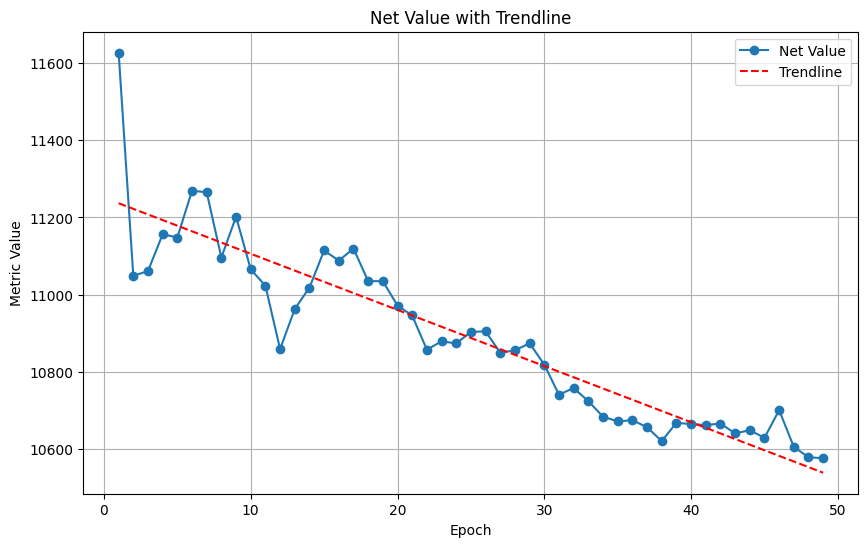

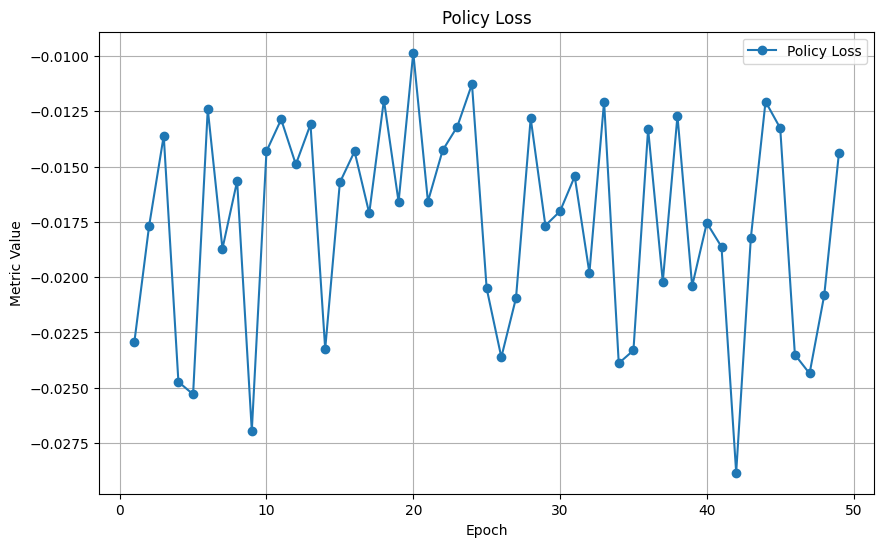

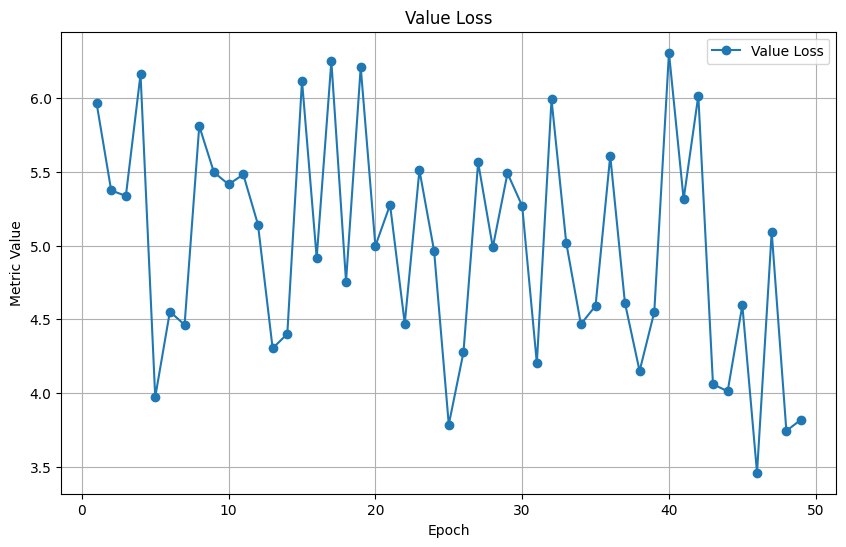

2024-11-25 05:14:35,879	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 05:14:35,948	INFO trainable.py:161 -- Trainable.setup took 19.456 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 05:14:35,950	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.2
Training iteration 1, Hyperparameter tuned = 0.2
Epoch 1: Policy Loss=-0.008985410146415233, Value Loss=7.8259085690975185
Training iteration 2, Hyperparameter tuned = 0.2
Epoch 2: Policy Loss=-0.020609701462090017, Value Loss=7.803518184423447
Training iteration 3, Hyperparameter tuned = 0.2
Epoch 3: Policy Loss=-0.01863208260620013, Value Loss=7.16839647769928
Training iteration 4, Hyperparameter tuned = 0.2
Epoch 4: Policy Loss=-0.012756684385240078, Value Loss=6.981694110631943
Training iteration 5, Hyperparameter tuned = 0.2
Epoch 5: Policy Loss=-0.008589820843189955, Value Loss=6.001265603899956
Training iteration 6, Hyperparameter tuned = 0.2
Epoch 6: Policy Loss=-0.019457892663776875, Value Loss=6.20441464304924
Training iteration 7, Hyperparameter tuned = 0.2
Epoch 7: Policy Loss=-0.011960818246006966, Value Loss=6.547177039384842
Training iteration 8, Hyperparameter tuned = 0.2
Epoch 8: Policy Loss=-0.013833863819018006, Value 

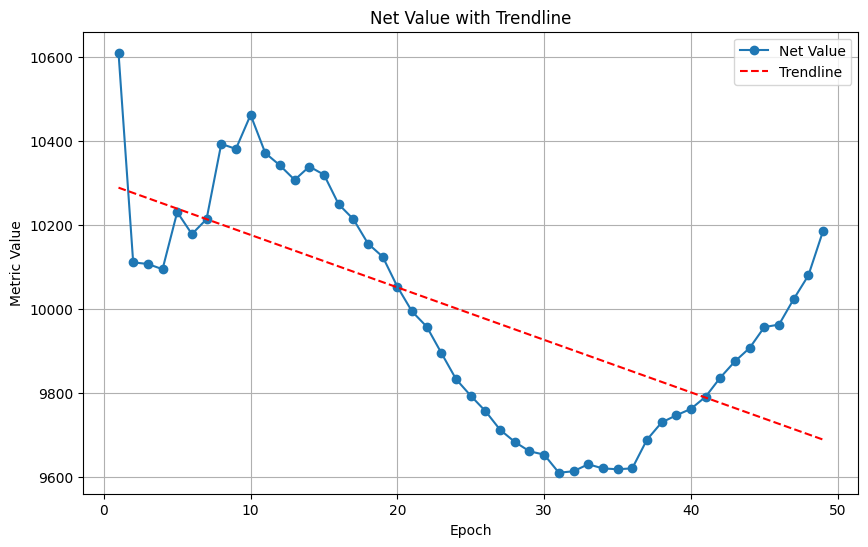

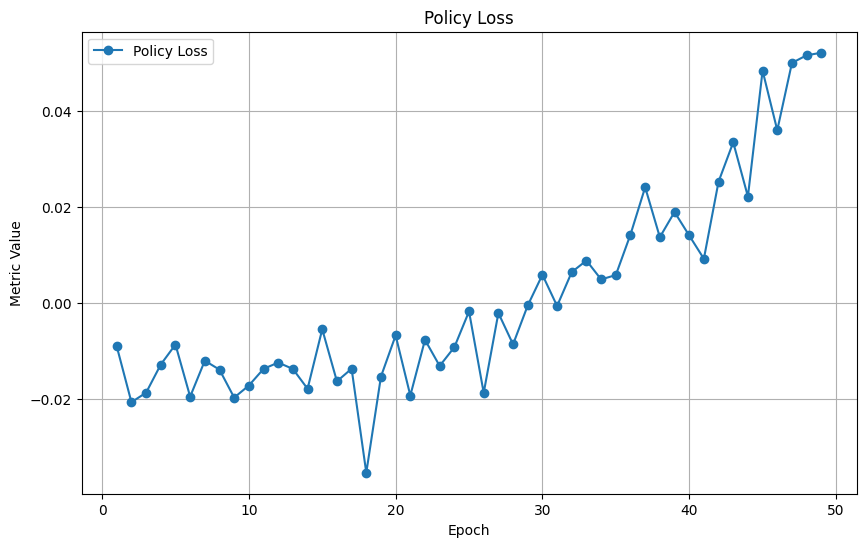

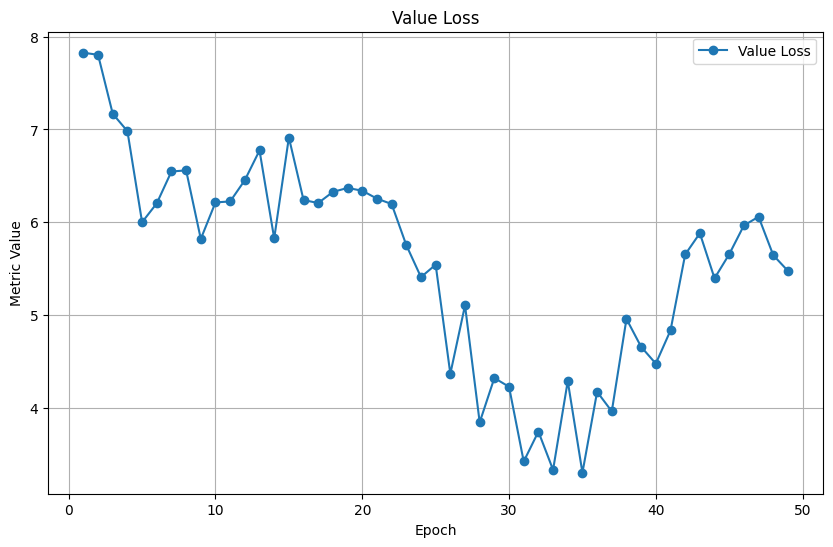

2024-11-25 06:21:49,890	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 06:21:49,966	INFO trainable.py:161 -- Trainable.setup took 21.181 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 06:21:49,969	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.3
Training iteration 1, Hyperparameter tuned = 0.3
Epoch 1: Policy Loss=-0.010662142783403397, Value Loss=9.249650285243987
Training iteration 2, Hyperparameter tuned = 0.3
Epoch 2: Policy Loss=-0.013550248444080353, Value Loss=9.385726027488708
Training iteration 3, Hyperparameter tuned = 0.3
Epoch 3: Policy Loss=-0.011290133744478226, Value Loss=8.960570684671403
Training iteration 4, Hyperparameter tuned = 0.3
Epoch 4: Policy Loss=-0.008275017254054546, Value Loss=8.293674170970917
Training iteration 5, Hyperparameter tuned = 0.3
Epoch 5: Policy Loss=-0.018147467435337603, Value Loss=8.433638380765915
Training iteration 6, Hyperparameter tuned = 0.3
Epoch 6: Policy Loss=-0.020937676653265954, Value Loss=7.70386125922203
Training iteration 7, Hyperparameter tuned = 0.3
Epoch 7: Policy Loss=-0.018370769531466068, Value Loss=8.720828076601029
Training iteration 8, Hyperparameter tuned = 0.3
Epoch 8: Policy Loss=-0.01932875834405422, Value 

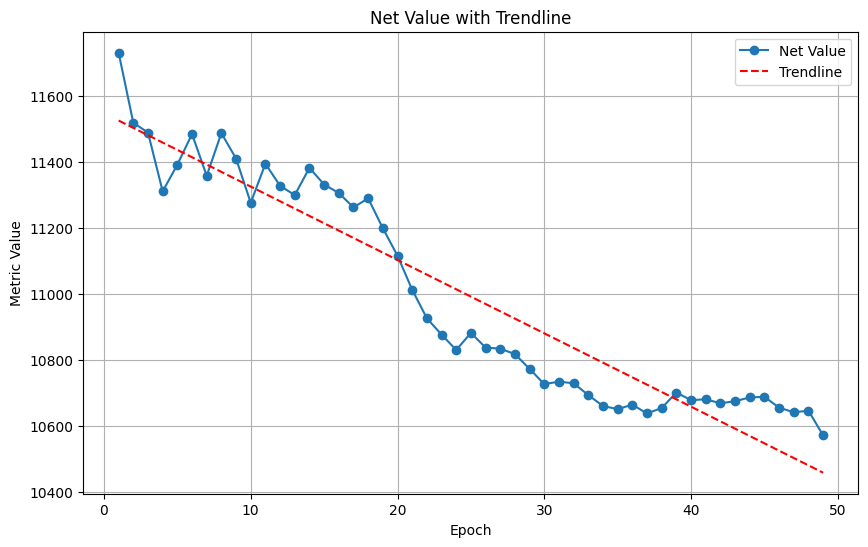

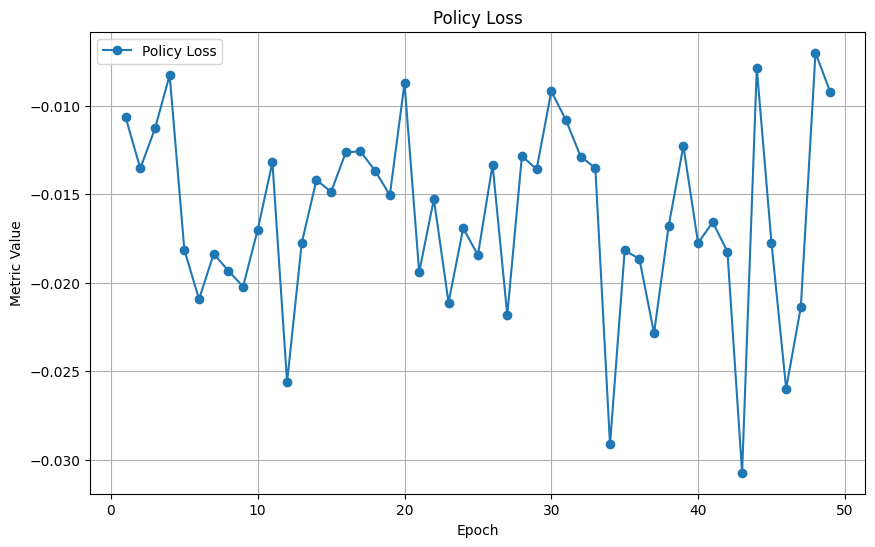

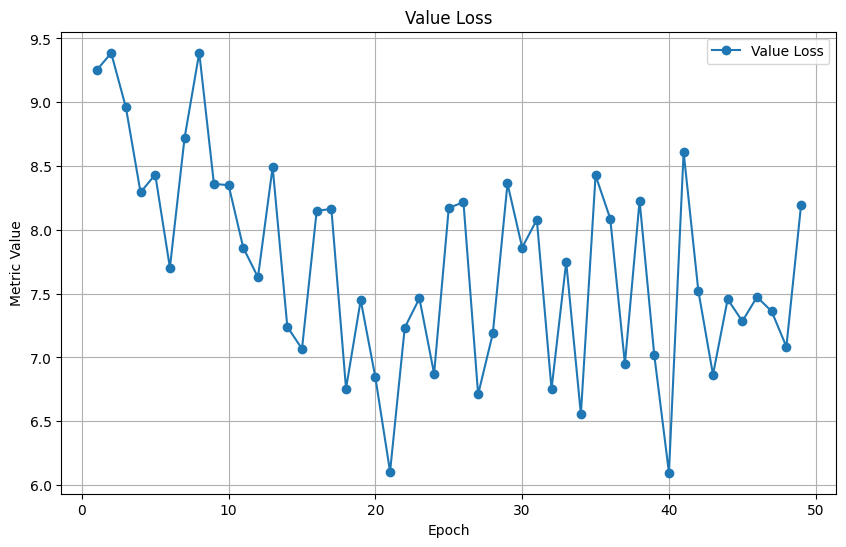

2024-11-25 07:29:44,458	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 07:29:44,526	INFO trainable.py:161 -- Trainable.setup took 22.498 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 07:29:44,529	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.4
Training iteration 1, Hyperparameter tuned = 0.4
Epoch 1: Policy Loss=-0.011162414569407702, Value Loss=9.041177470684051
Training iteration 2, Hyperparameter tuned = 0.4
Epoch 2: Policy Loss=-0.021905480436980724, Value Loss=8.632314944267273
Training iteration 3, Hyperparameter tuned = 0.4
Epoch 3: Policy Loss=-0.012360948175191878, Value Loss=8.390567409992219
Training iteration 4, Hyperparameter tuned = 0.4
Epoch 4: Policy Loss=-0.01570902667939663, Value Loss=8.990610382556916
Training iteration 5, Hyperparameter tuned = 0.4
Epoch 5: Policy Loss=-0.011851398572325707, Value Loss=9.390387289524078
Training iteration 6, Hyperparameter tuned = 0.4
Epoch 6: Policy Loss=-0.016172571321949363, Value Loss=8.351527333259583
Training iteration 7, Hyperparameter tuned = 0.4
Epoch 7: Policy Loss=-0.01712796138599515, Value Loss=9.030475044250489
Training iteration 8, Hyperparameter tuned = 0.4
Epoch 8: Policy Loss=-0.01043730621226132, Value L

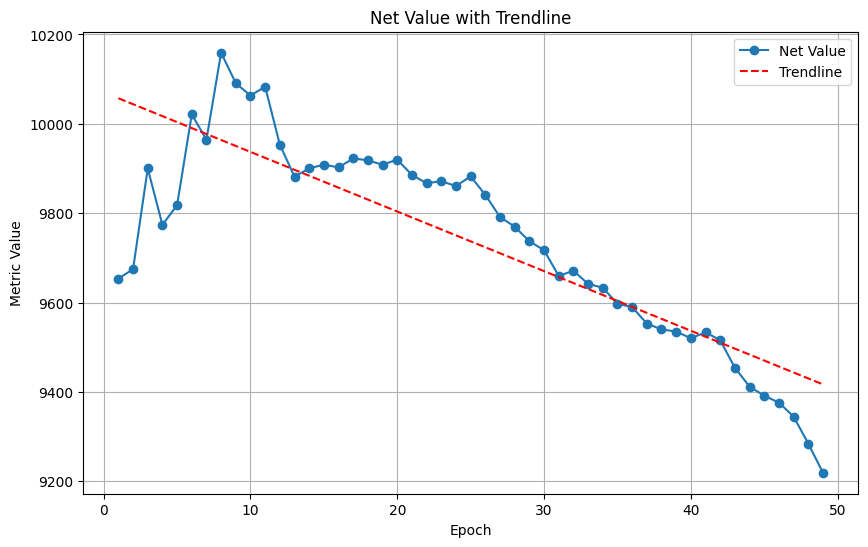

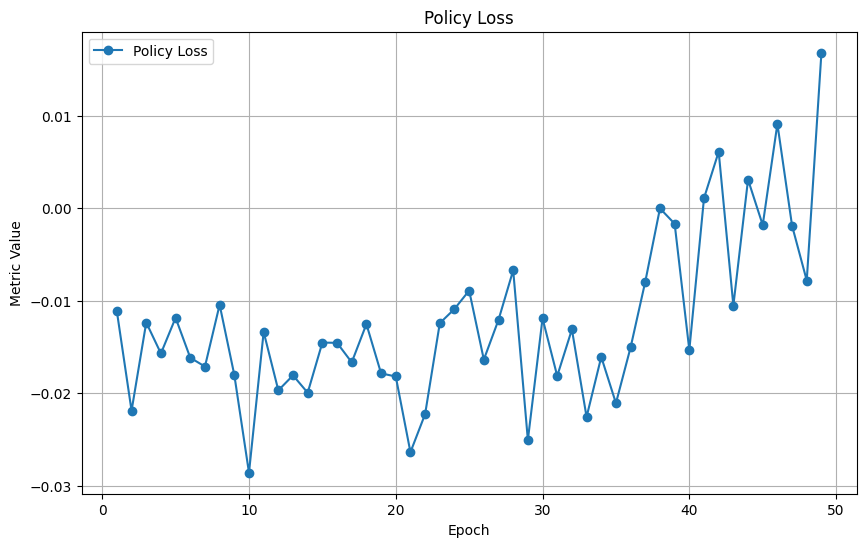

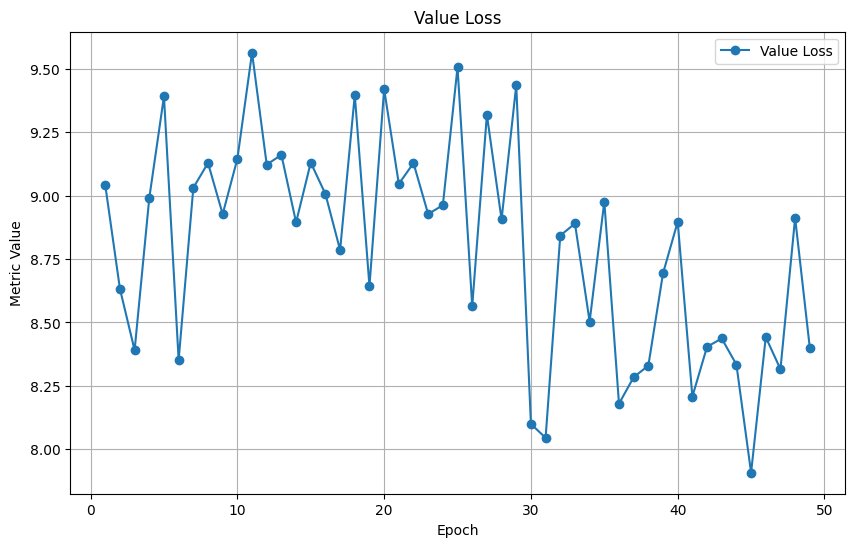

2024-11-25 08:37:18,912	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 08:37:18,978	INFO trainable.py:161 -- Trainable.setup took 19.627 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 08:37:18,980	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.5
Training iteration 1, Hyperparameter tuned = 0.5
Epoch 1: Policy Loss=-0.01725472943391651, Value Loss=9.30775463938713
Training iteration 2, Hyperparameter tuned = 0.5
Epoch 2: Policy Loss=-0.022057827673852445, Value Loss=9.735939507484437
Training iteration 3, Hyperparameter tuned = 0.5
Epoch 3: Policy Loss=-0.008831442780792714, Value Loss=9.89921451807022
Training iteration 4, Hyperparameter tuned = 0.5
Epoch 4: Policy Loss=-0.01590992886573076, Value Loss=9.666075503826141
Training iteration 5, Hyperparameter tuned = 0.5
Epoch 5: Policy Loss=-0.017606124617159366, Value Loss=9.603708126544952
Training iteration 6, Hyperparameter tuned = 0.5
Epoch 6: Policy Loss=-0.011375503521412611, Value Loss=9.400848925113678
Training iteration 7, Hyperparameter tuned = 0.5
Epoch 7: Policy Loss=-0.013825648613274098, Value Loss=9.052115597724914
Training iteration 8, Hyperparameter tuned = 0.5
Epoch 8: Policy Loss=-0.009910856634378433, Value Lo

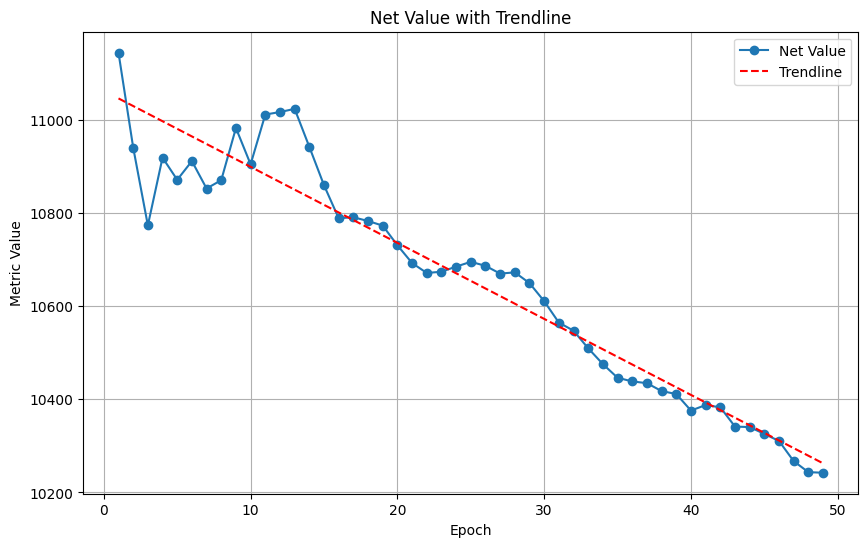

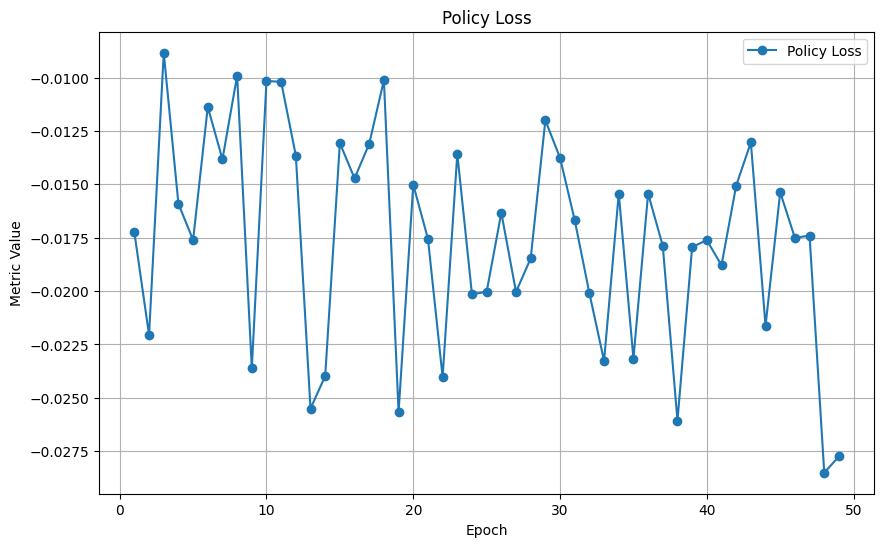

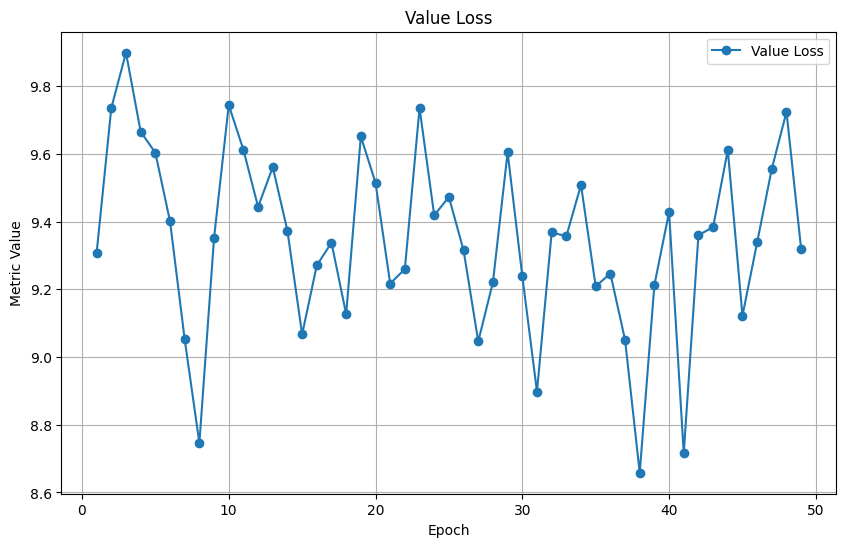

2024-11-25 09:44:28,303	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 09:44:28,369	INFO trainable.py:161 -- Trainable.setup took 18.229 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 09:44:28,371	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.6
Training iteration 1, Hyperparameter tuned = 0.6
Epoch 1: Policy Loss=-0.011047189384698867, Value Loss=9.517052850723267
Training iteration 2, Hyperparameter tuned = 0.6
Epoch 2: Policy Loss=-0.027979900408536196, Value Loss=9.839216256141663
Training iteration 3, Hyperparameter tuned = 0.6
Epoch 3: Policy Loss=-0.011506823981180787, Value Loss=9.719953615665435
Training iteration 4, Hyperparameter tuned = 0.6
Epoch 4: Policy Loss=-0.012449105950072408, Value Loss=9.884406654834747
Training iteration 5, Hyperparameter tuned = 0.6
Epoch 5: Policy Loss=-0.01569480771198869, Value Loss=9.488148305416107
Training iteration 6, Hyperparameter tuned = 0.6
Epoch 6: Policy Loss=-0.013245869507081807, Value Loss=9.869793691635131
Training iteration 7, Hyperparameter tuned = 0.6
Epoch 7: Policy Loss=-0.01951010271906853, Value Loss=9.45195169210434
Training iteration 8, Hyperparameter tuned = 0.6
Epoch 8: Policy Loss=-0.014333849791437387, Value L

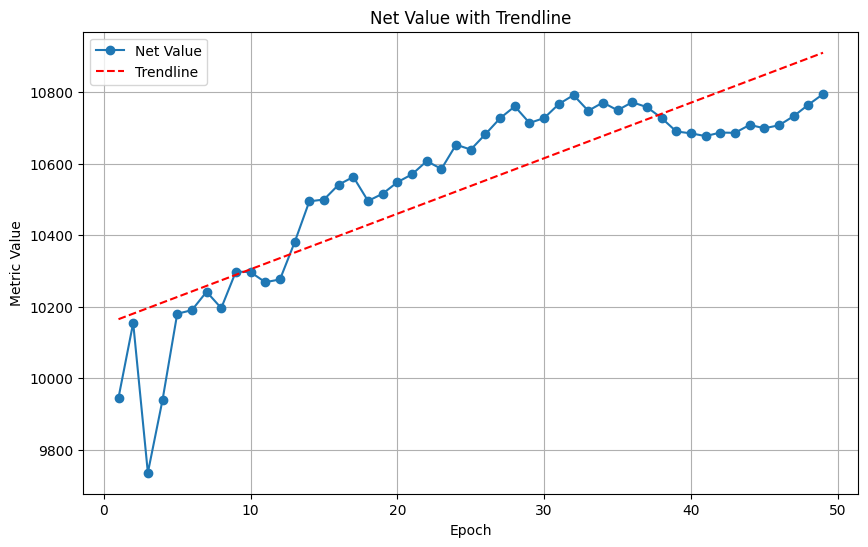

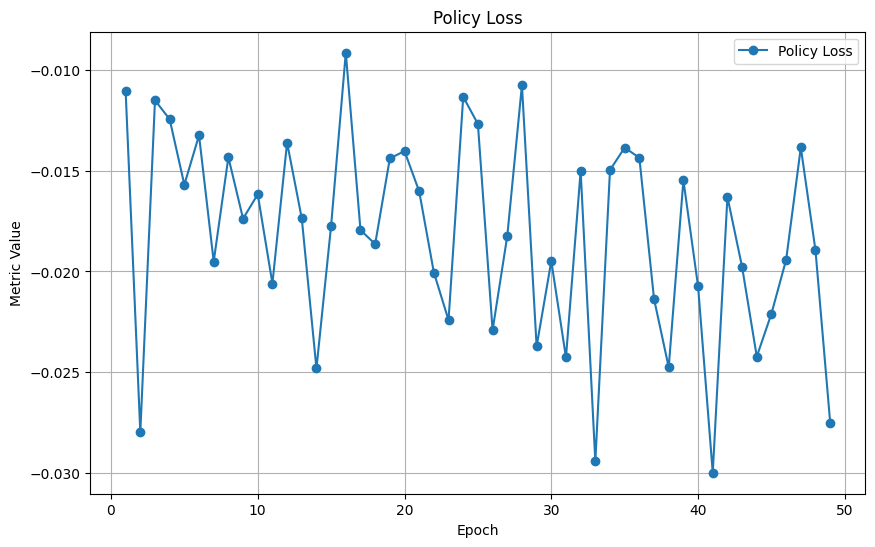

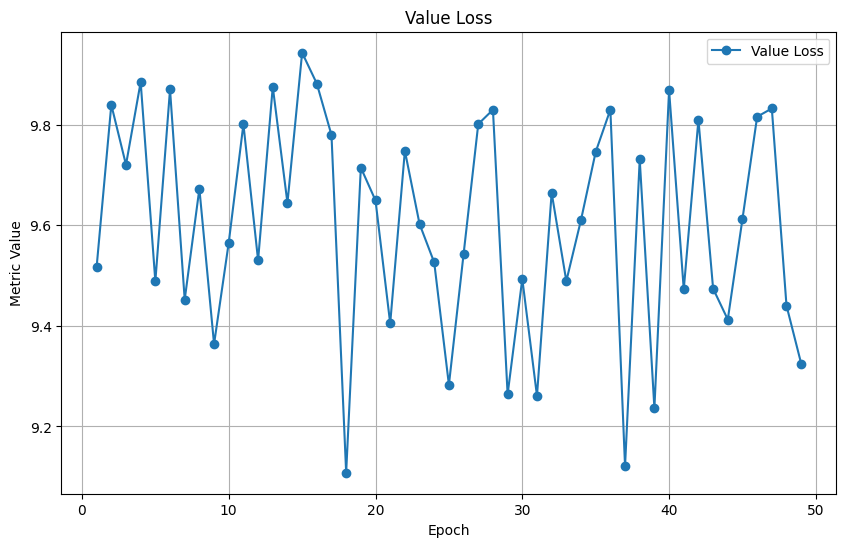

2024-11-25 10:51:35,872	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 10:51:35,936	INFO trainable.py:161 -- Trainable.setup took 17.452 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 10:51:35,938	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.7
Training iteration 1, Hyperparameter tuned = 0.7
Epoch 1: Policy Loss=-0.02251255325973034, Value Loss=9.823178284168243
Training iteration 2, Hyperparameter tuned = 0.7
Epoch 2: Policy Loss=-0.015275937542319297, Value Loss=9.937736287117005
Training iteration 3, Hyperparameter tuned = 0.7
Epoch 3: Policy Loss=-0.01988108417019248, Value Loss=9.977532217502594
Training iteration 4, Hyperparameter tuned = 0.7
Epoch 4: Policy Loss=-0.012707391269505024, Value Loss=9.814001140594483
Training iteration 5, Hyperparameter tuned = 0.7
Epoch 5: Policy Loss=-0.014040559157729149, Value Loss=10.0
Training iteration 6, Hyperparameter tuned = 0.7
Epoch 6: Policy Loss=-0.027484913617372514, Value Loss=9.769636645317078
Training iteration 7, Hyperparameter tuned = 0.7
Epoch 7: Policy Loss=-0.015555173978209496, Value Loss=9.781352648735046
Training iteration 8, Hyperparameter tuned = 0.7
Epoch 8: Policy Loss=-0.011891555227339267, Value Loss=9.808634

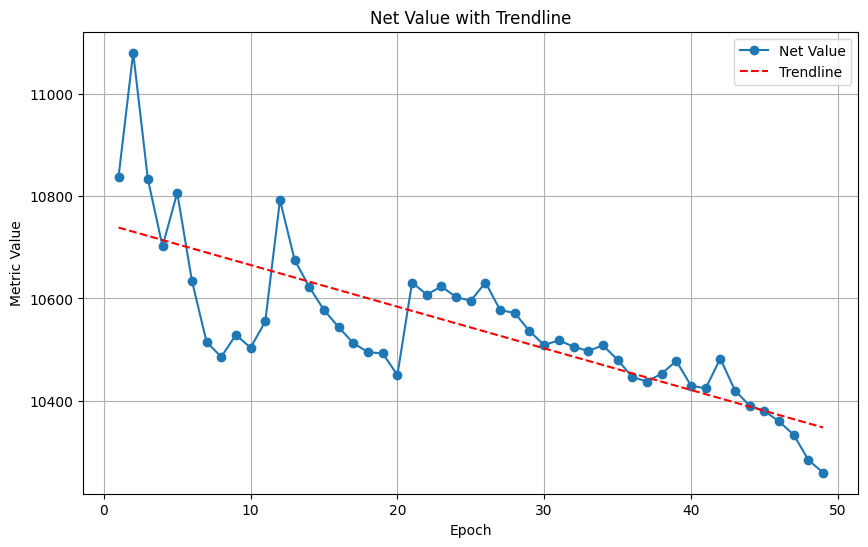

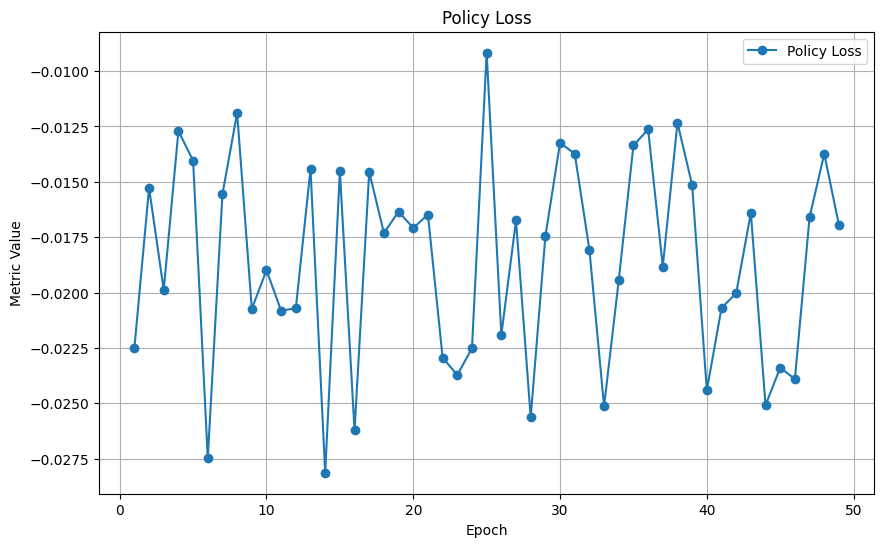

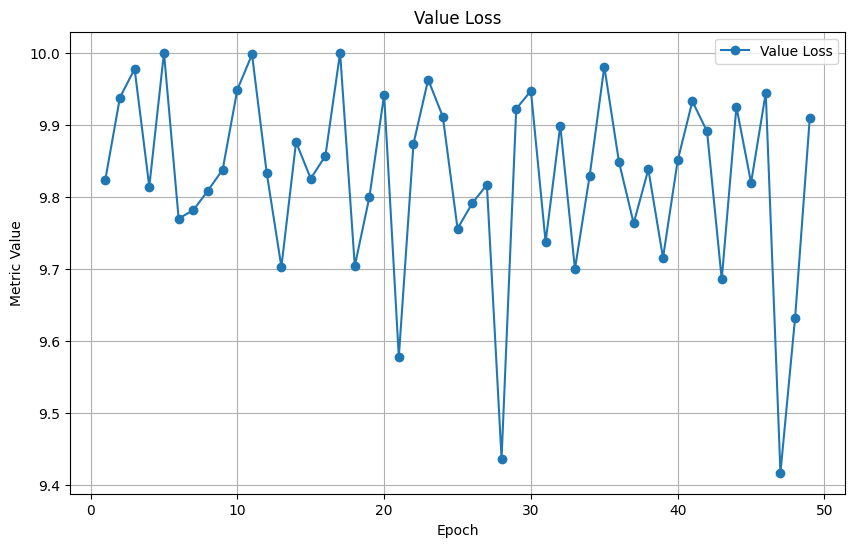

2024-11-25 11:59:08,639	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 11:59:08,704	INFO trainable.py:161 -- Trainable.setup took 18.862 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 11:59:08,707	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.8
Training iteration 1, Hyperparameter tuned = 0.8
Epoch 1: Policy Loss=-0.014153906684368849, Value Loss=9.981646573543548
Training iteration 2, Hyperparameter tuned = 0.8
Epoch 2: Policy Loss=-0.007650422230362892, Value Loss=9.879838447570801
Training iteration 3, Hyperparameter tuned = 0.8
Epoch 3: Policy Loss=-0.022469550669193268, Value Loss=9.923410391807556
Training iteration 4, Hyperparameter tuned = 0.8
Epoch 4: Policy Loss=-0.030277750827372073, Value Loss=9.977616920471192
Training iteration 5, Hyperparameter tuned = 0.8
Epoch 5: Policy Loss=-0.019778016693890094, Value Loss=9.978896586894988
Training iteration 6, Hyperparameter tuned = 0.8
Epoch 6: Policy Loss=-0.010819963235408068, Value Loss=9.87105906009674
Training iteration 7, Hyperparameter tuned = 0.8
Epoch 7: Policy Loss=-0.017532554529607294, Value Loss=9.975263345241547
Training iteration 8, Hyperparameter tuned = 0.8
Epoch 8: Policy Loss=-0.013621961325407028, Value

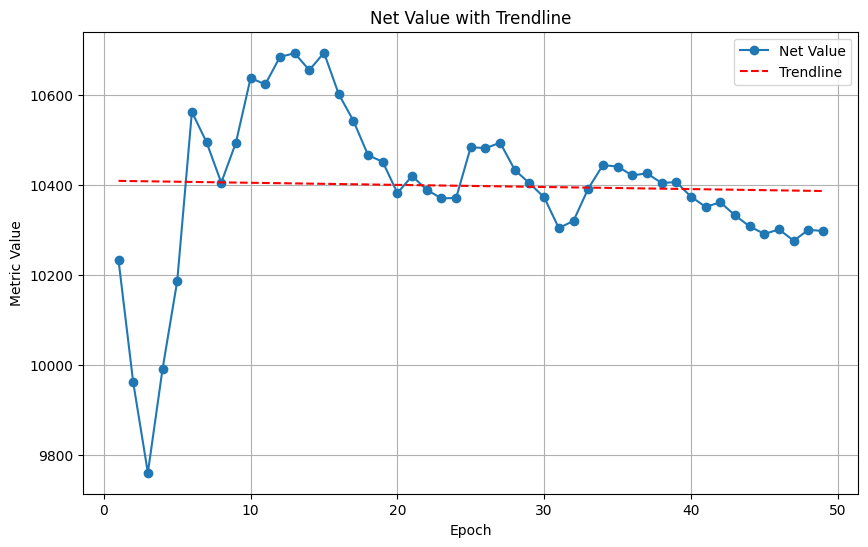

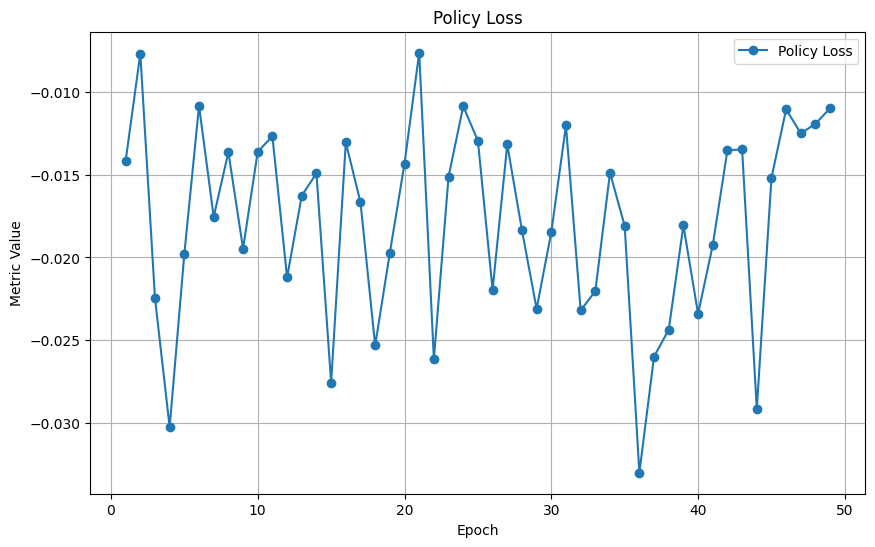

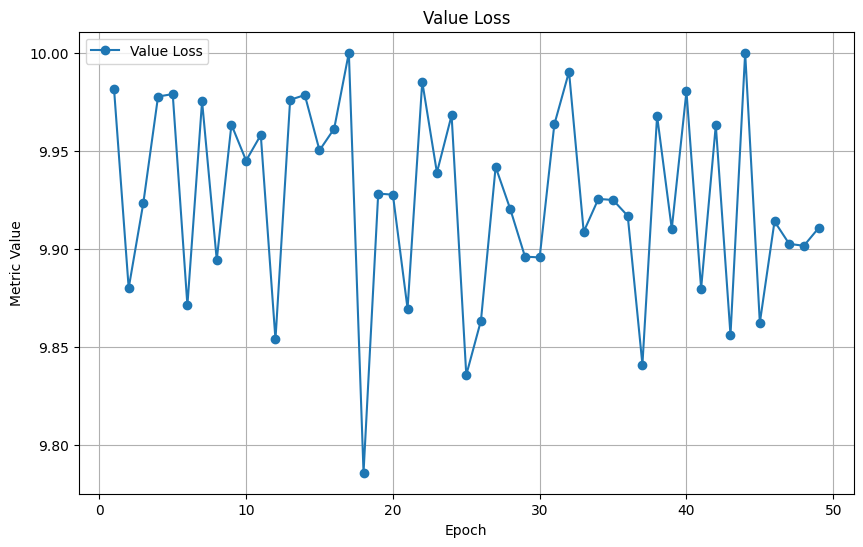

2024-11-25 13:06:34,402	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 13:06:34,485	INFO trainable.py:161 -- Trainable.setup took 25.475 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 13:06:34,491	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 0.9
Training iteration 1, Hyperparameter tuned = 0.9
Epoch 1: Policy Loss=-0.0059498397912830115, Value Loss=9.980532338619232
Training iteration 2, Hyperparameter tuned = 0.9
Epoch 2: Policy Loss=-0.024495200629462487, Value Loss=9.909155480861664
Training iteration 3, Hyperparameter tuned = 0.9
Epoch 3: Policy Loss=-0.01710035990457982, Value Loss=9.982265183925628
Training iteration 4, Hyperparameter tuned = 0.9
Epoch 4: Policy Loss=-0.01063281912356615, Value Loss=10.0
Training iteration 5, Hyperparameter tuned = 0.9
Epoch 5: Policy Loss=-0.01969435766339302, Value Loss=10.0
Training iteration 6, Hyperparameter tuned = 0.9
Epoch 6: Policy Loss=-0.020932576786726713, Value Loss=9.97566715478897
Training iteration 7, Hyperparameter tuned = 0.9
Epoch 7: Policy Loss=-0.018294890485703943, Value Loss=9.904638032913208
Training iteration 8, Hyperparameter tuned = 0.9
Epoch 8: Policy Loss=-0.020968013368546964, Value Loss=10.0
Training iteratio

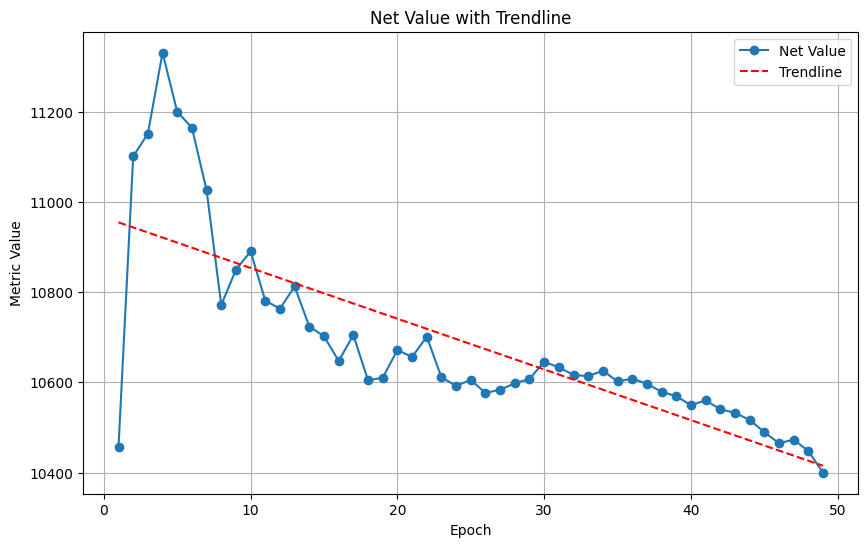

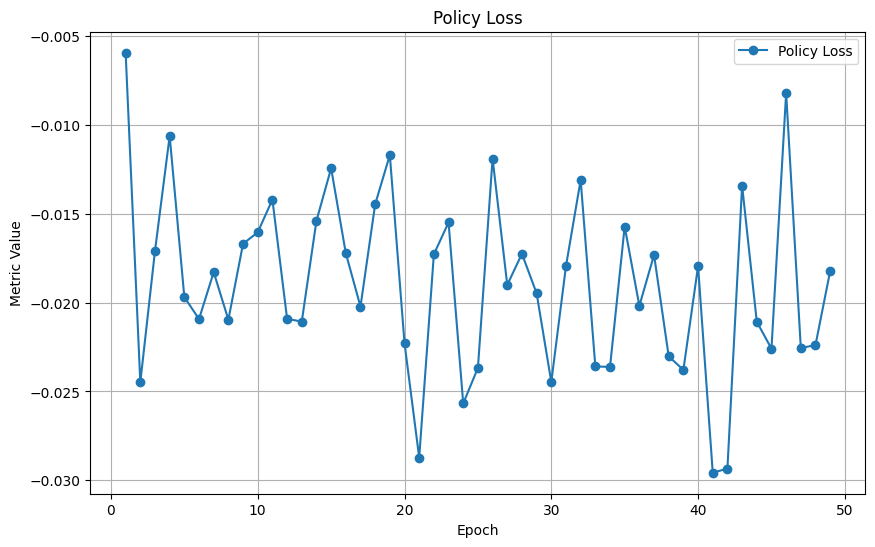

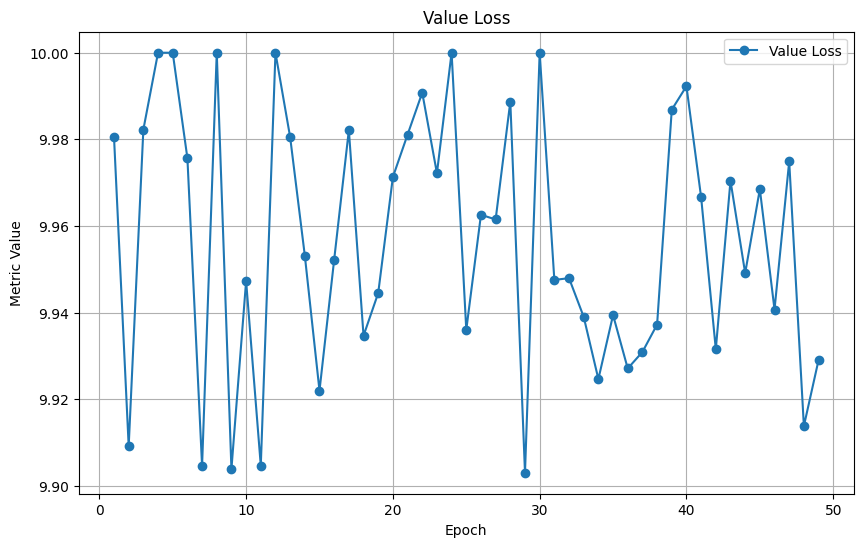

In [ ]:
ray.init(ignore_reinit_error=True)

def env_creator(env_config):
    return PortfolioOptimizationEnv(env_config)

register_env('my_portfolio_env', env_creator)

smoothing_factor_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

eval_rewards = {}
eval_net_prices = {}

def evaluate(trainer, env, num_episodes=10):
    all_rewards = []
    net_prices = []

    for episode in range(num_episodes):
        episode_reward = 0
        done = False
        truncated = False
        obs = env.reset()

        while not done and not truncated:
            if isinstance(obs, tuple):
                obs_input = obs[0]
            elif isinstance(obs, dict):
                obs_input = obs["obs"]
            else:
                obs_input = obs

            action = trainer.compute_single_action(obs_input, explore=False)
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward

        all_rewards.append(episode_reward)
        net_price = env.net_price[-1]
        net_prices.append(net_price)

    return all_rewards, net_prices

for sf in smoothing_factor_list:
    config['env_config']['smoothing_factor'] = sf
    config['val_env_config']['smoothing_factor'] = sf

    algo = (
        PPOConfig()
        .environment('my_portfolio_env', env_config=config['env_config'])
        .framework('torch')
        .resources(num_gpus=1)
        .env_runners(num_env_runners=config['num_workers'])
        .training(
            model=config['model'],
            lr=config['lr'],
            train_batch_size=config['train_batch_size'],
            num_epochs=config['num_epochs']
        )
        .api_stack(
            enable_rl_module_and_learner=False,
            enable_env_runner_and_connector_v2=False
        )
        .rollouts(sample_timeout_s=300)
        .callbacks(CustomMetricsCallback)
        .build()
    )

    num_epochs = 50
    epoch_net_values = []
    epoch_policy_loss = []
    epoch_value_loss = []

    for i in range(num_epochs):
        print(f"Training iteration {i}, Hyperparameter tuned = {sf}")
        result = algo.train()
        if i != 0:
            policy_loss = result["info"]["learner"]["default_policy"]["learner_stats"]["policy_loss"]
            value_loss = result["info"]["learner"]["default_policy"]["learner_stats"]["vf_loss"]
            net_value = result["env_runners"]["custom_metrics"]["final_net_price_mean"]
            epoch_policy_loss.append(policy_loss)
            epoch_value_loss.append(value_loss)
            epoch_net_values.append(net_value)
            print(f"Epoch {i}: Policy Loss={policy_loss}, Value Loss={value_loss}")
            torch.cuda.empty_cache()

    epochs = range(1, len(epoch_policy_loss) + 1)
    epochs = np.array(epochs)
    epoch_net_values = np.array(epoch_net_values)

    coefficients = np.polyfit(epochs, epoch_net_values, deg=1)
    trendline = np.polyval(coefficients, epochs)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_net_values, marker='o', label='Net Value')
    plt.plot(epochs, trendline, color='red', linestyle='--', label='Trendline')

    plt.title(f'Net Value with Trendline')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()



    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_policy_loss, marker='o', label='Policy Loss')
    plt.title(f'Policy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_value_loss, marker='o', label='Value Loss')
    plt.title(f'Value Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()


    evaluation_env = PortfolioOptimizationEnv(config['val_env_config'])
    all_rewards, net_prices = evaluate(algo, evaluation_env, num_episodes=10)
    evaluation_env.close()

    eval_rewards[sf] = all_rewards
    eval_net_prices[sf] = net_prices



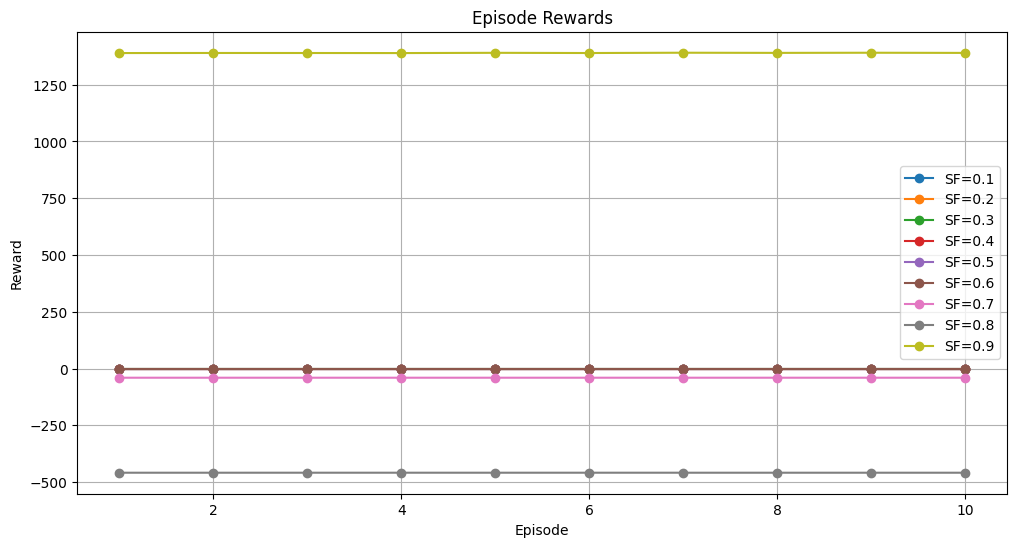

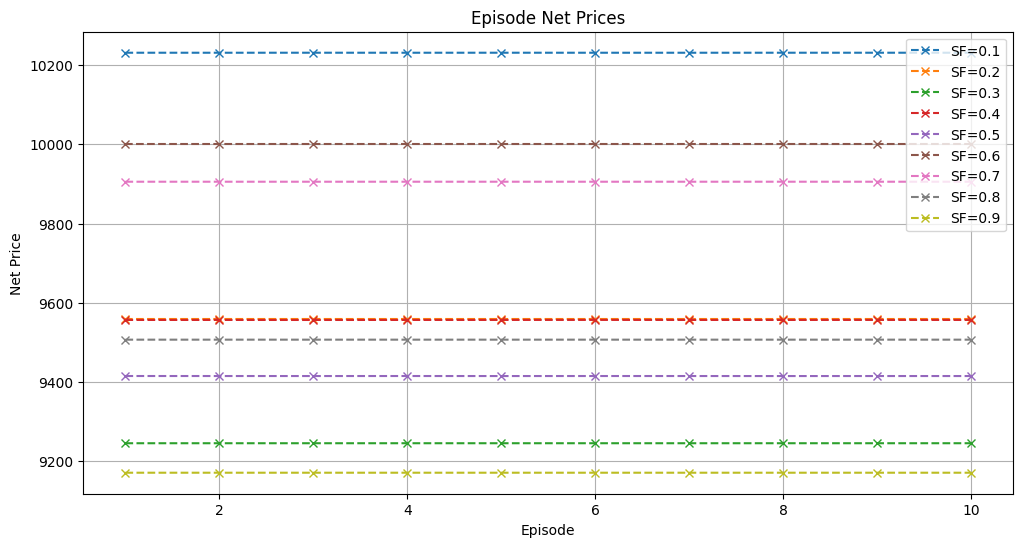

In [ ]:
plt.figure(figsize=(12, 6))
for sf, rewards in eval_rewards.items():
    episodes = range(1, len(rewards) + 1)
    plt.plot(episodes, rewards, marker='o', linestyle='-', label=f'SF={sf}')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for sf, net_prices in eval_net_prices.items():
    episodes = range(1, len(net_prices) + 1)
    plt.plot(episodes, net_prices, marker='x', linestyle='--', label=f'SF={sf}')
plt.xlabel('Episode')
plt.ylabel('Net Price')
plt.title('Episode Net Prices')
plt.legend()
plt.grid(True)
plt.show()

Save the model

In [ ]:
checkpoint_path = algo.save()
print(f"Checkpoint saved at: {checkpoint_path}")

Checkpoint saved at: TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/tmp/tmpnig_la6_), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'cur_kl_coeff': 0.675, 'cur_lr': 0.00010000000000000002, 'total_loss': 9.918655309677124, 'policy_loss': -0.018228147332556545, 'vf_loss': 9.929039719104766, 'vf_explained_var': 8.446723222732544e-06, 'kl': 0.011620303912786767, 'entropy': 5.192174831628799, 'entropy_coeff': 0.0}, 'model': {}, 'num_grad_updates_lifetime': 19800.5, 'diff_num_grad_updates_vs_sampler_policy': 199.5}}, 'num_env_steps_sampled': 25600, 'num_env_steps_trained': 25600, 'num_agent_steps_sampled': 25600, 'num_agent_steps_trained': 25600}, 'env_runners': {'episode_reward_max': 122467.93055812993, 'episode_reward_min': -911034.2104398755, 'episode_reward_mean': -14415.127793629772, 'episode_len_mean': 237.0, 'episode_media': {}, 'episodes_timesteps_total': 23700, 'policy_reward_min': {'